# **Technical Job Skills Analysis Using OpenAi and NER NLP**

## Web Scraping using Beautifulsoup

In [1]:
import requests
import time
from bs4 import BeautifulSoup
import random
import pandas as pd

### Get job Ids from Website

In [25]:
Jobtitle= input("Enter Job role: ")
title=Jobtitle.replace(" ", "%20").lower()

jobId_list=[]

for x in range(25, 5000, 25):

  url=f"https://www.linkedin.com/jobs-guest/jobs/api/seeMoreJobPostings/search?keywords={title}&location=United%20States&geoId=103644278&trk=public_jobs_jobs-search-bar_search-submit&position=1&pageNum=0&currentJobId=3962428485&start={x}"

  response=requests.get(url)
  time.sleep(1)

  jl=response.text
  job_list=BeautifulSoup(jl, "html.parser")
  jobs=job_list.find_all("li")


  for job in jobs:
      job_div = job.find("div", class_="base-card")
      if job_div and job_div.has_attr("data-entity-urn"):
          job_id = job_div["data-entity-urn"].split(":")[3]
          jobId_list.append(job_id)

jobId_list


Enter Job role: data analyst


['3993970121',
 '3994742487',
 '3993668352',
 '3991552996',
 '3995318770',
 '3988422367',
 '3987328985',
 '3993190759',
 '3995527750',
 '3995543289',
 '3990450518',
 '3991538422',
 '3944543664',
 '3995318770',
 '3994773789',
 '3992206087',
 '3992753239',
 '3993463452',
 '3994646347',
 '3994639318',
 '3995544094',
 '3983341791',
 '3989835910',
 '3987392174',
 '3985697878',
 '3994664237',
 '3990032533',
 '3989136242',
 '3993957828',
 '3993805689',
 '3986484956',
 '3993952479',
 '3986490175',
 '3995196656',
 '3993665356',
 '3991670689',
 '3995228921',
 '3989191577',
 '3993295187',
 '3988195032',
 '3990988873',
 '3989204386',
 '3989910589',
 '3995595259',
 '3994117397',
 '3992335082',
 '3990680343',
 '3991792190',
 '3985849267',
 '3995246386',
 '3993976485',
 '3991363370',
 '3989184880',
 '3987140553',
 '3950094343',
 '3989781110',
 '3993809186',
 '3993299435',
 '3994707692',
 '3994976949',
 '3992713719',
 '3989203347',
 '3994967298',
 '3985648137',
 '3988132653',
 '3987279746',
 '39874289

In [26]:
len(jobId_list)

308

### Get Job description for each Job Id

In [27]:
import pandas as pd

job_data_list=[]

for jobid in jobId_list:

  job_url=f"https://www.linkedin.com/jobs/view/{jobid}"
  response=requests.get(job_url)

  time.sleep(1)

  jp=response.text
  job_post=BeautifulSoup(jp, "html.parser")
  job_post_div= job_post.find("div", class_="top-card-layout__entity-info-container")

  try:
    job_title_h1= job_post_div.find("h1", class_="top-card-layout__title").get_text()
  except:
    job_title_h1= None

  try:
    job_org_a= job_post_div.find("a", class_="topcard__org-name-link").get_text(strip=True)
  except:
    job_org_a= None

  try:
    job_desc= job_post.find("div", class_="show-more-less-html__markup").get_text(separator='\n', strip=True)
  except:
    job_desc= None
  jobs_positings={}

  jobs_positings["Job Id"]=jobid
  jobs_positings["Job Title"]= job_title_h1
  jobs_positings["Company Name"]=job_org_a
  jobs_positings["Job Description"]=job_desc

  job_data_list.append(jobs_positings)

df=pd.DataFrame(job_data_list)

df.head(120)

,Job Id,Job Title,Company Name,Job Description
0,3993970121,None,None,None
1,3994742487,None,None,None
2,3993668352,Data Analyst II,IntePros,Compensation Range:\n$35.00 - $43.50/hr\nWelco...
3,3991552996,Data Analyst,Valve+Meter Performance Marketing,This is an onsite role that requires commuting...
4,3995318770,Data Analyst (Graduate/Remote),Bright Interactive,Bright Digital Solutions is a female-led digit...
...,...,...,...,...
115,3993328683,Business Intelligence Analyst,Forsyth Barnes,Title:\nBusiness Intelligence Analyst\nLocatio...
116,3985372442,Data Analyst,SideRamp,About SideRamp\nSideRamp allows professionals ...
117,3992830016,None,None,None
118,3986996880,Senior Data Analyst,Cirkul,What is Cirkul?\nCirkul is a rapidly growing b...


## Data Cleaning

In [28]:
df.isna().sum()

,0
Job Id,0
Job Title,102
Company Name,102
Job Description,102


In [30]:
n=len(df.dropna())
n

206

In [34]:
df=df.dropna()

## First Approach: langchain to impliment chunks, embeddings, vectore stores and openai api

In [33]:
!pip install cassio langchain openai tiktoken pinecone-client langchain-community langchain-pinecone

In [35]:
import openai
import langchain
import langchain
import pinecone
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.embeddings import OpenAIEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain.llms import OpenAI

### Divide Data into Chunks to reduce Token size for further application

In [36]:
# divide into chunks


text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size=500,
    chunk_overlap=50,
)

df_string=df["Job Description"].head(1).to_string()

chunks=text_splitter.split_text(df_string)

### vector Embeddings and vector storage

In [37]:
embeddings= OpenAIEmbeddings(model="text-embedding-3-small", openai_api_key="*****************************************")

In [ ]:
# text = "This is a test query."
# query_result = embeddings.embed_query(text)
# len(query_result)

In [38]:
from pinecone import Pinecone, ServerlessSpec


import os
os.environ['PINECONE_API_KEY'] = '***************************'

index = "jobskilldesc"

vecStore = PineconeVectorStore.from_texts(chunks, embeddings, index_name=index)



### OpenAI qa chain to ask a Question

In [40]:
queryPromt=input(f"Ask anything about {Jobtitle}?")


relavant_data = vecStore.similarity_search(queryPromt)
# print(relavant_data)
import os

os.environ['OPENAI_API_KEY'] = '********************************'

oAIllm = OpenAI(model_name="gpt-3.5-turbo-instruct", temperature=0.7)
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate


from langchain.chains.question_answering import load_qa_chain

chain = load_qa_chain(llm=oAIllm, chain_type="stuff")
output = chain.run(input_documents=relavant_data, question=queryPromt)
print(output)

Ask anything about data analyst?what is per hour salary for the role
 The per hour salary for the role is $35.00 - $43.50 per hour.


### openAI to get relavant skills (model is hallucinating)

In [41]:
queryPromt2="identify all the technical skills and technical tools mention in the given data. the output should be stricktly from the given data.the output response must be in JSON format with all two objects as technical skills and technical tools. don not add any word in the list if it is not present in the provided data "


prompt_template = PromptTemplate(
    input_variables=[ "query"],
    template="{query}"
)

chain2 = LLMChain(llm=oAIllm, prompt=prompt_template)

output2 = chain2.run(input_documents=relavant_data, query=queryPromt2)

print(output2)




{
    "Technical skills": [
        "Python",
        "Java",
        "C++",
        "HTML",
        "CSS",
        "JavaScript",
        "SQL",
        "Data analysis",
        "Machine learning",
        "Data visualization",
        "Web development",
        "Database management",
        "Object-oriented programming",
        "Responsive design",
        "Agile methodology",
        "Git",
        "Linux"
    ],
    "Technical tools": [
        "Jupyter Notebook",
        "PyCharm",
        "Eclipse",
        "Visual Studio Code",
        "Atom",
        "Sublime Text",
        "IntelliJ IDEA",
        "NetBeans",
        "MySQL",
        "MongoDB",
        "Oracle",
        "SQL Server",
        "Tableau",
        "Power BI",
        "Adobe Creative Suite"
    ]
}


## Second Approach: NER NLP (to tackle hallucination problem)


### loading list of skills

In [42]:
import pandas as pd

skill_list=[]

df_skill=pd.read_csv("https://raw.githubusercontent.com/mehulkapoor020/Jobskill/main/skills.csv")
# df_skill
for skill in df_skill["Skill"]:
  skill_list.append(skill.strip('\n'))
# len(skill_list)
skill_list.sort()

### preparing list in a format suitable our ner model

In [43]:
patterns=[]
for skill in skill_list:
  pattern={"label": "SKILL",
            "pattern": skill}
  patterns.append(pattern)
patterns

[{'label': 'SKILL', 'pattern': "'05"},
 {'label': 'SKILL', 'pattern': "'06"},
 {'label': 'SKILL', 'pattern': "'08"},
 {'label': 'SKILL', 'pattern': "'09"},
 {'label': 'SKILL', 'pattern': "'11"},
 {'label': 'SKILL', 'pattern': '(isc)2'},
 {'label': 'SKILL', 'pattern': '.10'},
 {'label': 'SKILL', 'pattern': '.17'},
 {'label': 'SKILL', 'pattern': '.com'},
 {'label': 'SKILL', 'pattern': '.htaccess'},
 {'label': 'SKILL', 'pattern': '.net'},
 {'label': 'SKILL', 'pattern': '.net'},
 {'label': 'SKILL', 'pattern': '.net clr'},
 {'label': 'SKILL', 'pattern': '.net compact framework'},
 {'label': 'SKILL', 'pattern': '.net core'},
 {'label': 'SKILL', 'pattern': '.net framework'},
 {'label': 'SKILL', 'pattern': '.net remoting'},
 {'label': 'SKILL', 'pattern': '0.10'},
 {'label': 'SKILL', 'pattern': '0.10.24'},
 {'label': 'SKILL', 'pattern': '0.12'},
 {'label': 'SKILL', 'pattern': '0.14.3'},
 {'label': 'SKILL', 'pattern': '0.48.2'},
 {'label': 'SKILL', 'pattern': '0.8'},
 {'label': 'SKILL', 'pattern

### Create Spacy model and loading the list

In [44]:
import spacy
from spacy.lang.en import English
from spacy.pipeline import EntityRuler


nlp = spacy.blank("en")

# nlp.analyze_pipes(pretty=True)

ruler =nlp.add_pipe("entity_ruler")

ruler.add_patterns(patterns)

nlp.to_disk("NER_Skill")

In [45]:
jd_str=""

i=int(n/2)

for y in range(i):
  index= y

  if df["Job Description"].iloc[index] != None:
    jd=df["Job Description"].iloc[index].strip("\n").lower()
    jd_str= jd_str + " " + jd

### Create Training Data for another model to recoganize new skills


In [46]:
dj_data=jd_str.split(". ")

train_data=[]

for text in dj_data:

  doc=nlp(text)

  entities=[]
  text_entity=[]

  for ent in doc.ents:
    entities.append((ent.start_char, ent.end_char, ent.label_))
  if len(entities)>0:
    text_entity=[ f"{doc}", {"entities": entities}]
    train_data.append(text_entity)

len(train_data)

730

In [47]:
import json
with open("Training_Data.json", 'w', encoding='utf-8') as json_file:
    json.dump(train_data, json_file, indent=4)

### Load training data into the new model

In [48]:
from spacy.tokens import DocBin
from tqdm import tqdm # wraps loops/iterators with a progress bar

nlp2 = spacy.blank("en")

doc_bin=DocBin()

from spacy.util import filter_spans

for text, annotation in tqdm(train_data):
  doc=nlp2.make_doc(text)
  ents=[]

  for start, end, label in annotation['entities']:
    span=doc.char_span(start, end, label=label, alignment_mode="contract")
    if span is None:
      print("skip entity")
    else:
      ents.append(span)
  doc.ents=ents

  doc_bin.add(doc)

doc_bin.to_disk("train.spacy")

100%|██████████| 730/730 [00:00<00:00, 866.66it/s]


In [50]:
!python -m spacy init fill-config base_config.cfg config.cfg


✔ Auto-filled config with all values
✔ Saved config
config.cfg
You can now add your data and train your pipeline:
python -m spacy train config.cfg --paths.train ./train.spacy --paths.dev ./dev.spacy


In [51]:
!python -m spacy train config.cfg --output ./ --paths.train ./train.spacy --paths.dev ./train.spacy


ℹ Saving to output directory: .
ℹ Using CPU

=========================== Initializing pipeline ===========================
✔ Initialized pipeline

============================= Training pipeline =============================
ℹ Pipeline: ['tok2vec', 'ner']
ℹ Initial learn rate: 0.001
E    #       LOSS TOK2VEC  LOSS NER  ENTS_F  ENTS_P  ENTS_R  SCORE 
---  ------  ------------  --------  ------  ------  ------  ------
  0       0          0.00    130.17    1.93   14.47    1.03    0.02
  0     200        130.93   5329.21   82.25   86.57   78.34    0.82
  1     400        125.04   2091.59   89.59   90.62   88.58    0.90
  1     600        137.10   1631.50   91.44   94.52   88.55    0.91
  2     800        149.25   1522.09   94.13   93.64   94.64    0.94
  3    1000        183.78   1194.64   95.94   96.60   95.29    0.96
  4    1200        202.44    996.71   96.97   97.02   96.91    0.97
  5    1400        235.25    941.37   97.88   98.44   97.32    0.98
  6    1600        280.90    751.97 

### Combining two models

In [52]:
nlp2=spacy.load("model-best")

# nlp.add_pipe(
#     "ner",
#     name="train_ner",
#     source=nlp2,
#     after="entity_ruler",
# )

# nlp.to_disk("NER_Skill")

nlp2.add_pipe(
    "entity_ruler",
    name="train_ner",
    source=nlp,
    after="ner",
)

nlp2.to_disk("NER_Skill_Final")

### Test final Model

In [53]:
demo_text= "The skill set required for the the JOB is sql and randomdata"


doc=nlp2(demo_text)

output=[]

for ent in doc.ents:
  if ent.text not in output:
    output.append(ent.text)
output.sort()
output

['randomdata', 'sql']

In [54]:
skillSet=[]

for y in range(i, n, 1):
  index= y
  result=[]

  if df["Job Description"].iloc[index] != None:
    test_data=df["Job Description"].iloc[index].strip("\n").lower()
    skill_data=nlp2(test_data)

    for ent in skill_data.ents:
      if ent.text not in result:
        result.append(ent.text)

  skillSet.extend(result)

skillSet.sort()

In [55]:
skill_count = {}

# Iterate through the list and count each item
for item in skillSet:
    if item in skill_count:
        skill_count[item] += 1
    else:
        skill_count[item] = 1

df_skill = pd.DataFrame(list(skill_count.items()), columns=['Skill', 'Count'])
df_skill = df_skill.sort_values(by='Count', ascending=False)

df_skill.head(50)

,Skill,Count
1525,skills,82
452,data,80
1425,reports,62
1190,other,58
1566,sql,53
1033,management,51
1660,technical,50
1589,status,46
334,computer science,44
1658,teams,43


### Filtering the suitable skills from dictionary

In [56]:
!pip install -qU langchain-openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.1 MB/s eta 0:00:00


In [57]:
from langchain_openai import ChatOpenAI

import os

os.environ['OPENAI_API_KEY'] = '**********************************'


llm = ChatOpenAI(
    model="gpt-4o",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

messages = [
    (
        "system",
        f"You are a technical job skills analyzer. From the provided dictionary, identify only the technical skills mentioned for {Jobtitle}. Remove any items that are not technical skills from the dictionary. Do not include anything that is not in the provided dictionary. The answer should be returned in Json format.",
    ),
    ("human", str(skill_count)),
]

ans = llm.invoke(messages)
print(ans.content)

```json
{
  ".net": 4,
  "a/b testing": 1,
  "access": 13,
  "adobe analytics": 1,
  "adobe campaign": 1,
  "agile": 9,
  "alteryx": 3,
  "analysis": 43,
  "analytical processing": 1,
  "analytics": 34,
  "api": 1,
  "apache": 1,
  "apple": 2,
  "application": 40,
  "applied mathematics": 2,
  "apps": 2,
  "architecting": 1,
  "architecture": 1,
  "atlassian": 1,
  "aws": 3,
  "azure": 4,
  "bash": 2,
  "big data": 3,
  "biostatistics": 1,
  "blockchain": 1,
  "business analysis": 8,
  "business intelligence": 18,
  "business intelligence tools": 1,
  "c": 4,
  "c++": 1,
  "campaign effectiveness": 1,
  "campaign strategy": 1,
  "cerner": 1,
  "cloud": 9,
  "cognos": 3,
  "computer applications": 2,
  "computer engineering": 2,
  "computer science": 44,
  "computer skills": 2,
  "computer vision": 1,
  "core java": 1,
  "crm": 8,
  "css": 3,
  "data": 80,
  "data acquisition": 1,
  "data analysis": 37,
  "data analytics": 36,
  "data architects": 2,
  "data architecture": 1,
  "data br

In [58]:
ans=ans.content.strip("```")
ans=ans.strip("json")

import ast # to convert str to dict
dictionary = ast.literal_eval(ans)

df_ai_skill = pd.DataFrame(list(dictionary.items()), columns=['Skill', 'Count'])
df_ai_skill = df_ai_skill.sort_values(by='Count', ascending=False)

df_ai_skill["Percentage"]=(df_ai_skill["Count"]/(n-i))*100

df_ai_skill.head(20)

,Skill,Count,Percentage
43,data,80,77.669903
173,reports,62,60.194175
176,sql,53,51.456311
37,computer science,44,42.718447
7,analysis,43,41.747573
171,reporting,42,40.776699
13,application,40,38.834951
45,data analysis,37,35.922330
46,data analytics,36,34.951456
132,it,35,33.980583


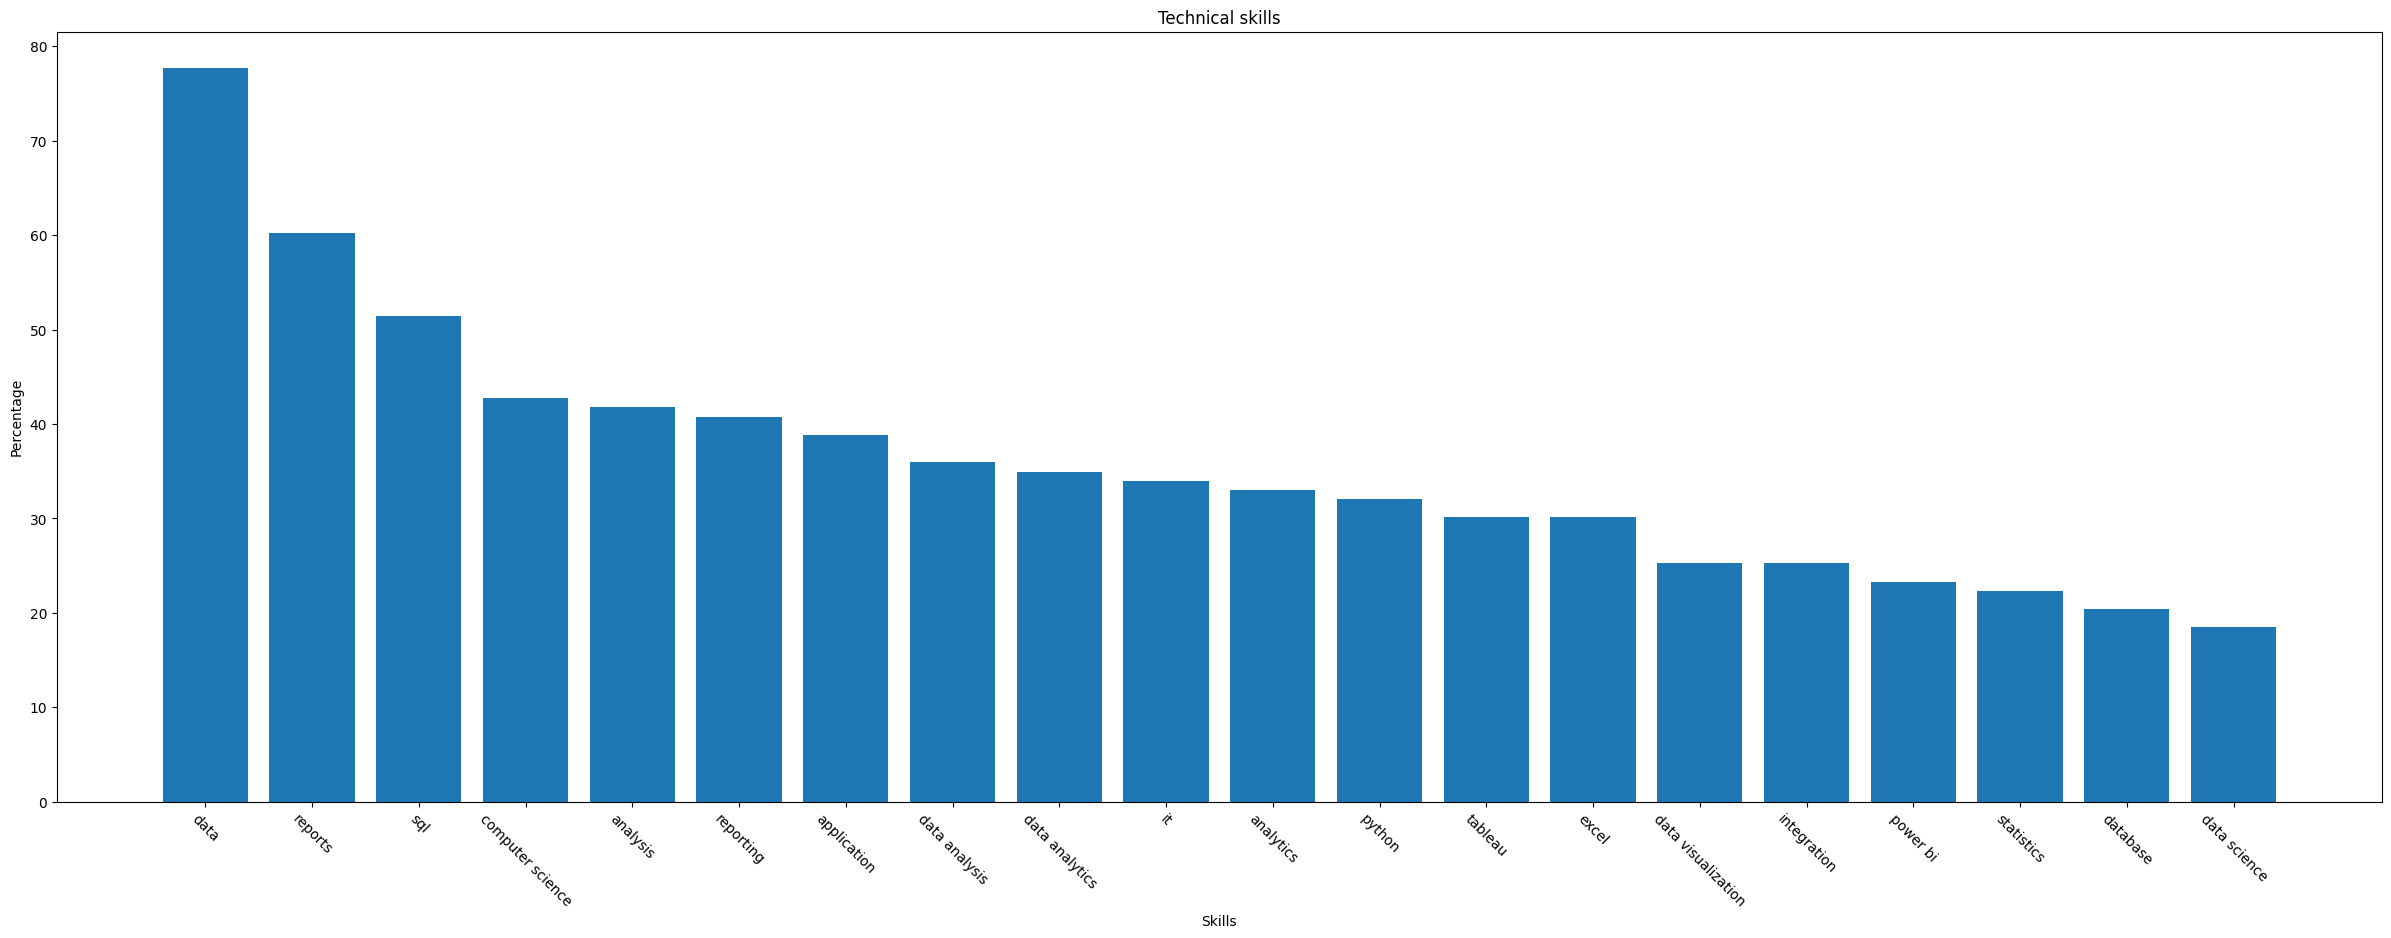

In [59]:
import matplotlib.pyplot as plt

df_ai_skill=df_ai_skill.head(20)
# x axis
sk= df_ai_skill["Skill"]

# y axis
perc = df_ai_skill["Percentage"]

plt.figure(figsize=(30, 10))
# Plotting the bar graph
plt.bar(sk, perc)
plt.xlabel('Skills')
plt.xticks(rotation=-45)
plt.ylabel('Percentage')
plt.title('Technical skills')
plt.show()